![logo sorbonne universite](rough_interface/logo_sorbonne.png)
# Modélisation de la réflexion d'une onde à une interface rugueuse
## Avancement de l'étude

Dans ce notebook sera consigné quelques résultats obtenus pour le projet de modélisation de la réflexion d'une onde à une interface rugueuse. Ce notebook peut également servir d'aide à la compréhension de l'utilisation de la classe *RoughInterfaceScattering*

On importe les librairies nécessaires

In [1]:
import rough_interface as ri
import numpy as np
from scipy.optimize import minimize as mini
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cart_real = lambda p,pb: plt.imshow(np.real(p.reshape([pb.res,pb.res])),\
                               origin='lower',vmin=-pb.amplitude,vmax=pb.amplitude,\
                               extent = pb.extent,interpolation='bicubic')

cart_abs = lambda p,pb: plt.imshow(abs(p.reshape([pb.res,pb.res])),\
                               origin='lower',vmin=0,vmax=pb.amplitude,\
                               extent = pb.extent,interpolation='bicubic')

In [3]:
pb = ri.RoughInterfaceScattering()

# Réflexion non classique
On remarque que lorsque on utilise une interface sinusoidale avec un certain jeu de paramètres (voir ci dessous), on obtient des couloirs dans l'amplitude de l'onde réfléchie.

Simulation de la réflexion d'une onde plane à une interface rugueuse.
8 processeur(s) utilisé(s)
Représentation de la configuration
RMS:0.105955971592, LAMBDA:1.7, LAMBDA/COS(THETA)/8:0.245336274489
Surface lisse au sens de Rayleigh


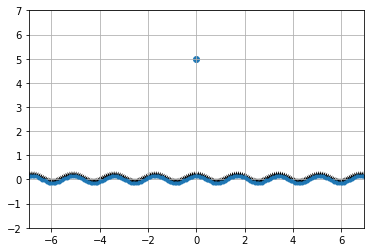

3.44396901131s
13.1138129234s


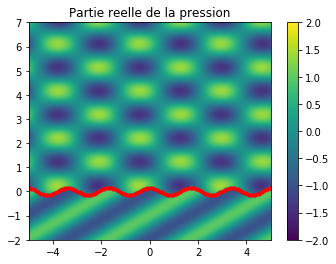

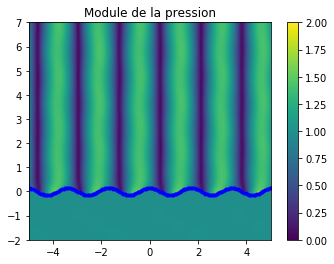

In [4]:
pb.create_interface('s_sinusoidale',.30,1.7,1500,50)
pb.set_source('plane',[0,5])
pb.set_frequency(200)
pb.set_omega([-5,5,-2,7],150,2)
pb.set_circle(2,[0,0])
pb.set_angle(30*3.14/180)

p,d = pb.start()

# Hypothèse onde plane
**On rapppele le critère de Rayleigh:**
\begin{align}
\sigma \cos (\theta) &< \frac{\lambda}{8} \\
\gamma \cos (\theta) &< \frac{\lambda}{8}
\end{align}

**Le critère de Rayleigh n'est pas une valeur intrinsèque, une interface peut être lisse pour une fréquence et un angle donné, et rugueux pour un autre couple de paramètres.**

*Attention, dans cette partie, le nombre d'élément est grand ($\approx 1500$) et donc peut conduire à des temps de calcul assez longs*

On se place dans le cadre d'une interface *aléatoire*.

In [16]:
lam = 340/pb.f

pb.create_interface('s_aleatoire',.4*lam,.4*lam,1500,30)
pb.set_omega([-5,5,-2,7],150,2)
p,d = pb.start(quiet = True)

3.25932383537s
13.2127380371s


On affiche la cartographie de pression.

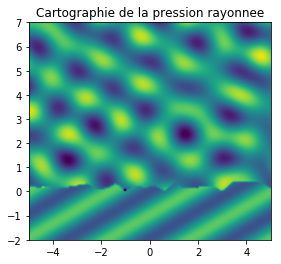

In [17]:
cart_real(p,pb)
plt.title('Cartographie de la pression rayonnee')
plt.show()

On voit qu'il y a a peu près un comportement d'onde plane très bruité, on va chercher à quantifier à quel point. Pour ce faire, on va calculer le cas idéal d'une onde réfléchie plane.

3.7398378849s
16.7565360069s


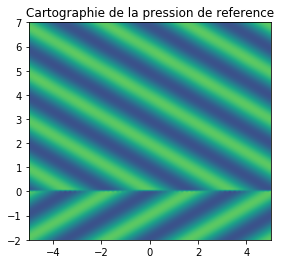

In [9]:
pb.create_interface('s_aleatoire',0,1,1500,30)
p_ref,d = pb.start(quiet=True)
cart_real(p_ref,pb)
plt.title('Cartographie de la pression de reference')
plt.show()

Pour objectivement comparer les deux cartographies, on va calculer l'écart entre les deux pour chaque point au dessus de l'interface.

In [18]:
def calcul_erreur(p,p_ref,crop):
    """Fonction qui à deux cartographies données renvoie la valeur RMS de l'erreur entre
    leur différence."""
    p_c = p.reshape([pb.res,pb.res])[crop:,:] #On reshape et on crop les cartographies
    p_ref_c = p_ref.reshape([pb.res,pb.res])[crop:,:]

    rms = lambda x:np.sqrt(np.mean(np.power(x,2))) #Création d'un shortcut RMS
    erreur = lambda x,y: rms(abs(y-x))/rms(abs(x)) #Création d'un shortcut ERREUR
    coef = mini(lambda a: erreur(p_ref_c,a*p_c),1).x[0] #Minimisation de l'erreur pour coef

    print('On obtient une erreur de {0}%, a={1:.2f}'.\
          format(int(100*erreur(p_ref_c,coef*p_c)),coef))
    if pb.rms*np.cos(pb.angle) < lam/8.:
        print('Surface lisse au sens de Rayleigh')
    else:
        print('Surface rugueuse au sens de Rayleigh')

In [19]:
calcul_erreur(p,p_ref,35)

On obtient une erreur de 95%, a=0.27
Surface rugueuse au sens de Rayleigh


Pour une interface présentant une rugosité de taille $0.4\lambda$, on obtient une onde réfléchie plane à $\approx5\%$, et rugueuse au sens de Rayleigh. On va diminuer la taille de la rugosité à $0.1\lambda$.

In [20]:
pb.create_interface('s_aleatoire',.1*lam,.1*lam,1500,30)
p,d = pb.start(quiet=True)

3.24658703804s
12.4865880013s


In [21]:
calcul_erreur(p,p_ref,35)

On obtient une erreur de 32%, a=0.94
Surface lisse au sens de Rayleigh


Pour une interface présentant des rugosités de l'ordre de $0.1\lambda$, on arrive à une onde réfléchie qui est à $\approx 70\%$ plane. On passe à $0.05\lambda$.

In [22]:
pb.create_interface('s_aleatoire',.05*lam,.05*lam,1500,30)
p,d = pb.start(quiet=True)
calcul_erreur(p,p_ref,35)

3.43578290939s
12.9346928596s
On obtient une erreur de 16%, a=0.99
Surface lisse au sens de Rayleigh


Pour une interface présentant des rugosités de l'ordre de $0.05\lambda$, on obtient une onde réfléchie plane à $\approx 80\%$. On passe à $0.02\lambda$.

In [14]:
pb.create_interface('s_aleatoire',.02*lam,.02*lam,1500,30)
p,d = pb.start(quiet=True)
calcul_erreur(p,p_ref,35)

3.31435608864s
18.4195251465s
On obtient une erreur de 6%, a=1.00
Surface lisse au sens de Rayleigh


Ici, on obtient une onde réfléchie plane à $\approx 95\%$. Le premier ressenti provenant de ces résultats et que le critère de Rayleigh est bien représentatif pour une interface aléatoire